# universal estimator (exp-3)

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
from scipy import stats
from scipy.stats import lognorm
from scipy.stats import yulesimon

def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

def sample_yulesimon(alpha, size):
    return yulesimon.rvs(alpha, loc=0, size=size)

def next_config(search_space):
    """
    return a (uniform) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    return np.random.uniform(low, high, size=1)[0]

In [3]:
def MAE(e, axis=-1):
    """mean absolute error"""
    return np.mean(np.abs(e), axis=axis)

NUM_BINS = 346

def predict_d(f, sample, d_true, search_space, num_trials=10, N=1000):
    """
    Learn parameters of f, from sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # experiment results
    res = {
        'search_space': [],
        'pred_params': [],
        'test_params': [],
        'pred_params_MAE': [],
        'd_true': d_true,
        'd_pred': [],
    }

    # number of observations in sample
    M = len(sample)
    N = N

    nbins = NUM_BINS
    
    # Generate a histogram for the input *sample*
    H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
    H_sample = np.reshape(H_sample, (1, -1))

    print(f'*** input histogram max value: {np.max(H_sample)}, nbins={nbins}')
    
    # Iterate   
    d_pred_array = np.zeros(num_trials)
    for trial_idx in range(num_trials):

        # 1. Generate synthetic data-sets (train/test) using f (within search_space)
        # -----------------------------------------------------------------------------------------------
        print()
        print(f'trial ({trial_idx+1}/{num_trials}) - search_space: {search_space}')
        print(f'generating data (M={M}, N={N}) ...', end=' ')

        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(search_space),
                                       nbins=nbins,
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)
        print(f'train histogram shape: {H_train.shape}', end=' ')

        # 2. Fit a DNN model to train-set and predict on test-set
        # -----------------------------------------------------------------------------------------------

        # train
        print(f'training dnn model ...')
        start_time = time.time()
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
        train_time = time.time() - start_time

        # predict
        pred_params = dnn_model.predict(H_test).flatten()

        # calc mean/max absolute error
        e = pred_params - test_params
        pred_params_MAE = MAE(e)
        print(f'*** test_MEAN_abs_error: {pred_params_MAE:.4f}')
        test_MAX_abs_error = np.max( np.abs(e) )
        print(f'*** test_MAX_abs_error: {test_MAX_abs_error:.4f}')
        test_3_STD = 3 * np.std(e)
        print(f'*** test_3_STD: {test_3_STD:.4f}')

        # 3. Predict the parameter (d_pred) on the input sample
        # -----------------------------------------------------------------------------------------------

        d_pred = dnn_model.predict(H_sample).flatten()[0]
        print(f'*** d_pred: {d_pred:.4f}', end=' ')
        print(f'*** abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
        d_pred_array[trial_idx] = d_pred

    return d_pred_array

### Show that d_pred is distributed Normally in the search_space
(with expected value at *d_true*)

In [4]:
# # d_true = 0.05 -> 0.12       # problem at low values
# # d_true = 0.08 -> 0.14       # problem at low values
# # d_true = 0.12 -> 0.15       # problem at low values
# # d_true = 0.23 -> 0.16       # problem at low values

# # d_true = 0.35 -> 0.36       # ok
# # d_true = 0.55  -> 0.56      # ok
# # d_true = 0.85 -> 0.847      # ok

# f = sample_lognormal
# sample = f(d_true, 256)
# search_space = [0.0, 1.0]

# d_pred_array = estimator_exp_3(
#     f=f, 
#     sample=sample, 
#     d_true=d_true, 
#     search_space=search_space, 
#     num_trials=10)

# mean=np.mean(d_pred_array)
# print(mean)
# _ = plt.hist(d_pred_array, bins=len(d_pred_array))

### Fit (lognormal)


param true value: 0.66

Iteration: 1 ---------------------------------------------------
*** input histogram max value: 127, nbins=346

trial (1/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0496
*** test_MAX_abs_error: 0.1975
*** test_3_STD: 0.1897
*** d_pred: 0.6816 *** abs(d_pred - d_true): 0.0216

trial (2/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0555
*** test_MAX_abs_error: 0.1593
*** test_3_STD: 0.1936
*** d_pred: 0.6873 *** abs(d_pred - d_true): 0.0273

trial (3/10) - search_space: [0.0, 1.0]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0591
*** test_MAX_abs_error: 0.2798
*** test_3_STD: 0.2151
*** d_pred: 0.6401 *** abs(d_pred - d_true): 0.0199

trial (4/10) - search_space: [0.0, 1.0]
generat

generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0228
*** test_MAX_abs_error: 0.0892
*** test_3_STD: 0.0840
*** d_pred: 0.6446 *** abs(d_pred - d_true): 0.0154

trial (10/10) - search_space: [0.572  0.6901]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0242
*** test_MAX_abs_error: 0.0774
*** test_3_STD: 0.0905
*** d_pred: 0.6694 *** abs(d_pred - d_true): 0.0094
*** mean: 0.638497
*** std: 0.018673
std_factor: 3
search_space: [0.5825 0.6945]

Iteration: 4 ---------------------------------------------------
*** input histogram max value: 127, nbins=346

trial (1/10) - search_space: [0.5825 0.6945]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0257
*** test_MAX_abs_error: 0.1034
*** test_3_STD: 0.0943
*** d_pred: 0.6500 *** abs(d_pred - d_true): 0.0100

trial (2/10) - searc

*** test_MEAN_abs_error: 0.0228
*** test_MAX_abs_error: 0.0798
*** test_3_STD: 0.0828
*** d_pred: 0.6297 *** abs(d_pred - d_true): 0.0303

trial (8/10) - search_space: [0.5868 0.6843]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0218
*** test_MAX_abs_error: 0.0791
*** test_3_STD: 0.0820
*** d_pred: 0.6312 *** abs(d_pred - d_true): 0.0288

trial (9/10) - search_space: [0.5868 0.6843]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0234
*** test_MAX_abs_error: 0.0864
*** test_3_STD: 0.0870
*** d_pred: 0.6614 *** abs(d_pred - d_true): 0.0014

trial (10/10) - search_space: [0.5868 0.6843]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0226
*** test_MAX_abs_error: 0.0803
*** test_3_STD: 0.0841
*** d_pred: 0.6546 *** abs(d_pred - d_true): 0.0054
*** mean: 0.640860
*** std: 0.

*** test_MEAN_abs_error: 0.0249
*** test_MAX_abs_error: 0.0974
*** test_3_STD: 0.0913
*** d_pred: 0.6244 *** abs(d_pred - d_true): 0.0356

trial (6/10) - search_space: [0.5784 0.6932]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0247
*** test_MAX_abs_error: 0.0886
*** test_3_STD: 0.0913
*** d_pred: 0.6378 *** abs(d_pred - d_true): 0.0222

trial (7/10) - search_space: [0.5784 0.6932]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0250
*** test_MAX_abs_error: 0.0928
*** test_3_STD: 0.0915
*** d_pred: 0.6031 *** abs(d_pred - d_true): 0.0569

trial (8/10) - search_space: [0.5784 0.6932]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0260
*** test_MAX_abs_error: 0.0982
*** test_3_STD: 0.0963
*** d_pred: 0.6111 *** abs(d_pred - d_true): 0.0489

trial (9/10) - search_space: [

*** test_MEAN_abs_error: 0.0084
*** test_MAX_abs_error: 0.0379
*** test_3_STD: 0.0301
*** d_pred: 0.6257 *** abs(d_pred - d_true): 0.0343

trial (4/10) - search_space: [0.6105 0.6389]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0076
*** test_MAX_abs_error: 0.0238
*** test_3_STD: 0.0277
*** d_pred: 0.6237 *** abs(d_pred - d_true): 0.0363

trial (5/10) - search_space: [0.6105 0.6389]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0083
*** test_MAX_abs_error: 0.0290
*** test_3_STD: 0.0297
*** d_pred: 0.6316 *** abs(d_pred - d_true): 0.0284

trial (6/10) - search_space: [0.6105 0.6389]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0082
*** test_MAX_abs_error: 0.0280
*** test_3_STD: 0.0299
*** d_pred: 0.6160 *** abs(d_pred - d_true): 0.0440

trial (7/10) - search_space: [

*** test_MEAN_abs_error: 0.0174
*** test_MAX_abs_error: 0.0572
*** test_3_STD: 0.0631
*** d_pred: 0.6305 *** abs(d_pred - d_true): 0.0295

trial (2/10) - search_space: [0.5859 0.6601]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0183
*** test_MAX_abs_error: 0.0740
*** test_3_STD: 0.0661
*** d_pred: 0.6004 *** abs(d_pred - d_true): 0.0596

trial (3/10) - search_space: [0.5859 0.6601]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0176
*** test_MAX_abs_error: 0.0673
*** test_3_STD: 0.0664
*** d_pred: 0.6387 *** abs(d_pred - d_true): 0.0213

trial (4/10) - search_space: [0.5859 0.6601]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0174
*** test_MAX_abs_error: 0.0570
*** test_3_STD: 0.0631
*** d_pred: 0.6168 *** abs(d_pred - d_true): 0.0432

trial (5/10) - search_space: [

*** test_MEAN_abs_error: 0.0213
*** test_MAX_abs_error: 0.0807
*** test_3_STD: 0.0783
*** d_pred: 0.6130 *** abs(d_pred - d_true): 0.0470
*** mean: 0.622448
*** std: 0.009450
std_factor: 3
search_space: [0.5941 0.6508]

Iteration: 18 ---------------------------------------------------
*** input histogram max value: 127, nbins=346

trial (1/10) - search_space: [0.5941 0.6508]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0157
*** test_MAX_abs_error: 0.0439
*** test_3_STD: 0.0556
*** d_pred: 0.6304 *** abs(d_pred - d_true): 0.0296

trial (2/10) - search_space: [0.5941 0.6508]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0150
*** test_MAX_abs_error: 0.0367
*** test_3_STD: 0.0524
*** d_pred: 0.6127 *** abs(d_pred - d_true): 0.0473

trial (3/10) - search_space: [0.5941 0.6508]
generating data (M=256, N=1000) ... train histogram shape: (750, 346

*** test_MEAN_abs_error: 0.0110
*** test_MAX_abs_error: 0.0358
*** test_3_STD: 0.0393
*** d_pred: 0.6284 *** abs(d_pred - d_true): 0.0316

trial (9/10) - search_space: [0.6058 0.6472]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0103
*** test_MAX_abs_error: 0.0386
*** test_3_STD: 0.0380
*** d_pred: 0.6166 *** abs(d_pred - d_true): 0.0434

trial (10/10) - search_space: [0.6058 0.6472]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0113
*** test_MAX_abs_error: 0.0316
*** test_3_STD: 0.0395
*** d_pred: 0.6206 *** abs(d_pred - d_true): 0.0394
*** mean: 0.625881
*** std: 0.006933
std_factor: 3
search_space: [0.6051 0.6467]

Iteration: 21 ---------------------------------------------------
*** input histogram max value: 127, nbins=346

trial (1/10) - search_space: [0.6051 0.6467]
generating data (M=256, N=1000) ... train histogram shape: (750, 34

*** test_MEAN_abs_error: 0.0199
*** test_MAX_abs_error: 0.0789
*** test_3_STD: 0.0732
*** d_pred: 0.6300 *** abs(d_pred - d_true): 0.0300

trial (7/10) - search_space: [0.5833 0.6664]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0196
*** test_MAX_abs_error: 0.0677
*** test_3_STD: 0.0708
*** d_pred: 0.6321 *** abs(d_pred - d_true): 0.0279

trial (8/10) - search_space: [0.5833 0.6664]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0203
*** test_MAX_abs_error: 0.0637
*** test_3_STD: 0.0733
*** d_pred: 0.6249 *** abs(d_pred - d_true): 0.0351

trial (9/10) - search_space: [0.5833 0.6664]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0188
*** test_MAX_abs_error: 0.0655
*** test_3_STD: 0.0683
*** d_pred: 0.6340 *** abs(d_pred - d_true): 0.0260

trial (10/10) - search_space: 

*** test_MEAN_abs_error: 0.0175
*** test_MAX_abs_error: 0.0669
*** test_3_STD: 0.0642
*** d_pred: 0.6289 *** abs(d_pred - d_true): 0.0311

trial (5/10) - search_space: [0.5897 0.6603]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0164
*** test_MAX_abs_error: 0.0477
*** test_3_STD: 0.0586
*** d_pred: 0.6267 *** abs(d_pred - d_true): 0.0333

trial (6/10) - search_space: [0.5897 0.6603]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0179
*** test_MAX_abs_error: 0.0542
*** test_3_STD: 0.0634
*** d_pred: 0.6361 *** abs(d_pred - d_true): 0.0239

trial (7/10) - search_space: [0.5897 0.6603]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0193
*** test_MAX_abs_error: 0.0625
*** test_3_STD: 0.0694
*** d_pred: 0.6487 *** abs(d_pred - d_true): 0.0113

trial (8/10) - search_space: [

*** test_MEAN_abs_error: 0.0095
*** test_MAX_abs_error: 0.0285
*** test_3_STD: 0.0347
*** d_pred: 0.6319 *** abs(d_pred - d_true): 0.0281

trial (3/10) - search_space: [0.6112 0.6472]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0093
*** test_MAX_abs_error: 0.0263
*** test_3_STD: 0.0331
*** d_pred: 0.6214 *** abs(d_pred - d_true): 0.0386

trial (4/10) - search_space: [0.6112 0.6472]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0110
*** test_MAX_abs_error: 0.0354
*** test_3_STD: 0.0387
*** d_pred: 0.6351 *** abs(d_pred - d_true): 0.0249

trial (5/10) - search_space: [0.6112 0.6472]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0101
*** test_MAX_abs_error: 0.0310
*** test_3_STD: 0.0354
*** d_pred: 0.6212 *** abs(d_pred - d_true): 0.0388

trial (6/10) - search_space: [

*** test_MEAN_abs_error: 0.0130
*** test_MAX_abs_error: 0.0430
*** test_3_STD: 0.0464
*** d_pred: 0.6231 *** abs(d_pred - d_true): 0.0369

trial (2/10) - search_space: [0.6036 0.6551]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0123
*** test_MAX_abs_error: 0.0334
*** test_3_STD: 0.0436
*** d_pred: 0.6349 *** abs(d_pred - d_true): 0.0251

trial (3/10) - search_space: [0.6036 0.6551]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0133
*** test_MAX_abs_error: 0.0422
*** test_3_STD: 0.0476
*** d_pred: 0.6186 *** abs(d_pred - d_true): 0.0414

trial (4/10) - search_space: [0.6036 0.6551]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0139
*** test_MAX_abs_error: 0.0548
*** test_3_STD: 0.0503
*** d_pred: 0.6225 *** abs(d_pred - d_true): 0.0375

trial (5/10) - search_space: [

*** test_MEAN_abs_error: 0.0082
*** test_MAX_abs_error: 0.0259
*** test_3_STD: 0.0299
*** d_pred: 0.6155 *** abs(d_pred - d_true): 0.0445
*** mean: 0.623050
*** std: 0.004804
std_factor: 3
search_space: [0.6086 0.6375]

Iteration: 35 ---------------------------------------------------
*** input histogram max value: 127, nbins=346

trial (1/10) - search_space: [0.6086 0.6375]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0080
*** test_MAX_abs_error: 0.0303
*** test_3_STD: 0.0283
*** d_pred: 0.6248 *** abs(d_pred - d_true): 0.0352

trial (2/10) - search_space: [0.6086 0.6375]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0082
*** test_MAX_abs_error: 0.0360
*** test_3_STD: 0.0301
*** d_pred: 0.6174 *** abs(d_pred - d_true): 0.0426

trial (3/10) - search_space: [0.6086 0.6375]
generating data (M=256, N=1000) ... train histogram shape: (750, 346

*** test_MEAN_abs_error: 0.0078
*** test_MAX_abs_error: 0.0284
*** test_3_STD: 0.0278
*** d_pred: 0.6279 *** abs(d_pred - d_true): 0.0321

trial (9/10) - search_space: [0.6102 0.6393]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0083
*** test_MAX_abs_error: 0.0388
*** test_3_STD: 0.0306
*** d_pred: 0.6145 *** abs(d_pred - d_true): 0.0455

trial (10/10) - search_space: [0.6102 0.6393]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0087
*** test_MAX_abs_error: 0.0280
*** test_3_STD: 0.0318
*** d_pred: 0.6192 *** abs(d_pred - d_true): 0.0408
*** mean: 0.620822
*** std: 0.006788
std_factor: 3
search_space: [0.6005 0.6412]

Iteration: 38 ---------------------------------------------------
*** input histogram max value: 127, nbins=346

trial (1/10) - search_space: [0.6005 0.6412]
generating data (M=256, N=1000) ... train histogram shape: (750, 34

*** test_MEAN_abs_error: 0.0086
*** test_MAX_abs_error: 0.0267
*** test_3_STD: 0.0305
*** d_pred: 0.6183 *** abs(d_pred - d_true): 0.0417

trial (7/10) - search_space: [0.6084 0.6389]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0084
*** test_MAX_abs_error: 0.0297
*** test_3_STD: 0.0310
*** d_pred: 0.6241 *** abs(d_pred - d_true): 0.0359

trial (8/10) - search_space: [0.6084 0.6389]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0076
*** test_MAX_abs_error: 0.0236
*** test_3_STD: 0.0276
*** d_pred: 0.6186 *** abs(d_pred - d_true): 0.0414

trial (9/10) - search_space: [0.6084 0.6389]
generating data (M=256, N=1000) ... train histogram shape: (750, 346) training dnn model ...
*** test_MEAN_abs_error: 0.0075
*** test_MAX_abs_error: 0.0233
*** test_3_STD: 0.0273
*** d_pred: 0.6221 *** abs(d_pred - d_true): 0.0379

trial (10/10) - search_space: 

OSError: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

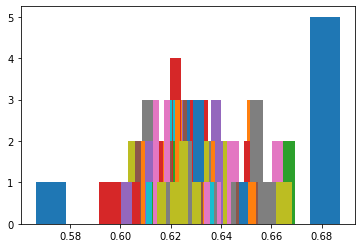

In [5]:
f = sample_lognormal
d_true = 0.92
# d_true = 0.85
# d_true = 0.66
search_space = [0.0, 1.0]

# f = sample_yulesimon
# d_true = 2.92
# search_space = [2.0, 3.0]

print()
print(f'param true value: {d_true}')
sample = f(d_true, 256)

def estimator_exp_3(f, sample, d_true, search_space, num_trials=10, N=1000):
    it = 0
    while True:
        it += 1
        print()
        print(f'Iteration: {it} ---------------------------------------------------')
        search_space_width = search_space[1] - search_space[0]
        N = max(1000, int(search_space_width*1000))
        d_pred_array = predict_d(
            f=f, 
            sample=sample, 
            d_true=d_true, 
            search_space=search_space, 
            N=N,
            num_trials=10)

        mean= np.mean(d_pred_array)
        print(f'*** mean: {mean:.6f}')

        std = np.std(d_pred_array)
        print(f'*** std: {std:.6f}')

        # narrow search_space
    #     std_factor = 1
    #     std_factor = 2
        std_factor = 3
        print(f'std_factor: {std_factor}')
        search_space = np.array([mean - std_factor * std,  mean + std_factor * std])
        print(f'search_space: {search_space}')

        nbins = len(d_pred_array)
        _ = plt.hist(d_pred_array, bins=nbins)

        search_space_width = search_space[1] - search_space[0]
        if search_space_width < 0.01:
            break


d_true = 0.66  
avg_d_pred = 0.660803  
100 predictions  
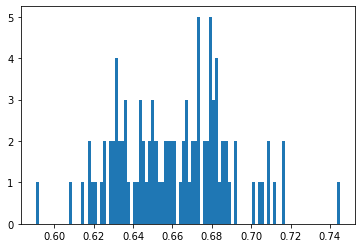
